In [2]:
import sys
import os
import folium
import numpy.ma as ma
from folium import Map, FeatureGroup, LayerControl
import rasterio
from shapely.geometry import box
import geopandas as gpd
from pyproj import CRS
from rasterio.mask import mask
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import rioxarray as rxr
from rasterio import plot
from shapely.geometry import mapping
import glob 

# Define whether to filter out values <0.1
remove_little_values = True

os.chdir('../ProcessModelResults/IdealisedProfiles/')
from my_functions_idealisedprofiles import *

### Read in the catchment boundary, and the boundaries for Kippax and Garforth

In [9]:
model_directory = '../../../../FloodModelling/Model_IdealisedProfiles/'

# Specify catchment area to add to plot
catchment_gdf = gpd.read_file('../../../../FloodModelling/Model_IdealisedProfiles/CatchmentLinDyke_exported.shp')

# Specify Kippax boundary
all_boundaries = gpd.read_file("../../../../FloodModelling/SubCatchmentBoundaries/KippaxBoundary/Parishes/Parishes_December_2016_FCB_in_England_and_Wales.shp")
kippax_boundary = all_boundaries[all_boundaries['par16nm'] == 'Kippax']

# Garforth boundary
garforth_boundary = gpd.read_file("../../../../FloodModelling/SubCatchmentBoundaries/GarforthBoundary/Garforth_edited.shp")
# Convert crs to BNG
garforth_boundary = garforth_boundary.to_crs("epsg:27700") 

# Garforth West boundary
garforth_west_boundary = gpd.read_file("../../../../FloodModelling/SubCatchmentBoundaries/FEH_Catchment_439950_432100/FEH_Catchment_439950_432100.shp")
# Convert crs to BNG
garforth_west_boundary = garforth_west_boundary.to_crs("epsg:27700") 

# Garforth East boundary
garforth_east_boundary = gpd.read_file("../../../../FloodModelling/SubCatchmentBoundaries/FEH_Catchment_439800_432050/FEH_Catchment_439800_432050.shp")
# Convert crs to BNG
garforth_east_boundary = garforth_east_boundary.to_crs("epsg:27700") 

# Kippax West boundary
kippax_west_boundary = gpd.read_file("../../../../FloodModelling/SubCatchmentBoundaries/FEH_Catchment_440950_429650/FEH_Catchment_440950_429650.shp")
# Convert crs to BNG
kippax_west_boundary = kippax_west_boundary.to_crs("epsg:27700") 

# South Catchment boundary
south_catchment_boundary = gpd.read_file("../../../../FloodModelling/SubCatchmentBoundaries/FEH_Catchment_443050_428550/FEH_Catchment_443050_428550.shp")
# Convert crs to BNG
south_catchment_boundary = south_catchment_boundary.to_crs("epsg:27700") 

### Read in the resized land cover file, clip it, update some parameters, save to landcover directory 

In [13]:
landcover_clipped, out_meta = open_and_clip( '../../../../FloodModelling/LandCoverData/LandCover_resized.tif')
out_meta.update({"nodata":np.nan, "dtype" :'float64' })
landcover_clipped[landcover_clipped == -2147483648] = np.nan
save_array_as_raster(landcover_clipped, '../../../../FloodModelling/LandCoverData/LandCover_clipped.tif', out_meta)

### Create a modified version of the data with flag for urban (10) and non-urban (11),  save to landcover directory

In [14]:
# Convert the 1 and 6 values to 10 (for urban) and the rest to 11 (for non-urban).  
landcover_mod =  np.where(landcover_clipped==1, 10, landcover_clipped)
landcover_mod =  np.where(landcover_mod==6, 10, landcover_mod)
# Convert the rest of the classes to 11
for i in [2,3,4,5,7,8,9]:
    landcover_mod =  np.where(landcover_mod==i, 11, landcover_mod)
save_array_as_raster(landcover_mod, '../../../../FloodModelling/LandCoverData/LandCover_urban_classification.tif', out_meta)

In [15]:
# Convert the 1 to 10 (for urban) and the rest to 11 (for non-urban).  
landcover_mod2 =  np.where(landcover_clipped==1, 10, landcover_clipped)
# Convert the rest of the classes to 11
for i in [2,3,4,5,6,7,8,9]:
    landcover_mod2 =  np.where(landcover_mod2==i, 11, landcover_mod2)
save_array_as_raster(landcover_mod2, '../../../../FloodModelling/LandCoverData/LandCover_urban_classification2.tif', out_meta)

#### Count the number of cells in each of the categories

In [16]:
values, counts = np.unique(landcover_mod, return_counts=True)
df=pd.DataFrame({'values':values,'WholeCatchment': counts})

### Plot - both original landcover data and classified urban/not urban data

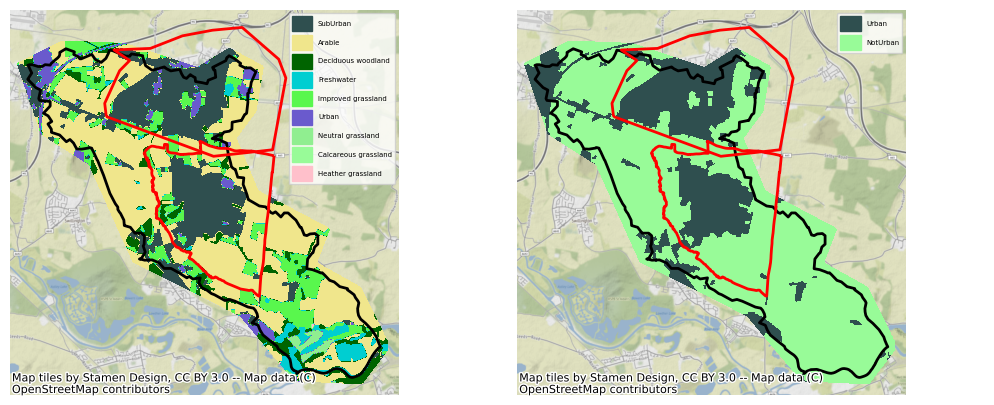

In [108]:
clipped = rasterio.open('../../../../FloodModelling/LandCoverData/LandCover_clipped.tif')
labels= ['SubUrban', 'Arable', 'Deciduous woodland', 'Freshwater', 'Improved grassland', 'Urban', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland']
colors = ['darkslategrey', 'khaki', 'darkgreen','darkturquoise','#59F74D', 'slateblue', 'lightgreen', 'palegreen', 'pink']
cmap = mpl.colors.ListedColormap(colors)

classified = rasterio.open('../../../../FloodModelling/LandCoverData/LandCover_urban_classification.tif')
labels_classified = ['Urban', 'NotUrban']
colors_classsified = ['darkslategrey', 'palegreen']
cmap_classified = mpl.colors.ListedColormap(colors_classsified)

fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))
catchment_gdf.plot(ax=axs[0], facecolor = 'None', edgecolor = 'black', linewidth = 2)
garforth_boundary.plot(ax=axs[0], facecolor = 'None', edgecolor = 'red', linewidth = 2)
kippax_boundary.plot(ax=axs[0], facecolor = 'None', edgecolor = 'red', linewidth = 2)
cx.add_basemap(axs[0], crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
plot.show((clipped, 1), ax= axs[0], cmap=cmap)

catchment_gdf.plot(ax=axs[1], facecolor = 'None', edgecolor = 'black', linewidth = 2)
garforth_boundary.plot(ax=axs[1], facecolor = 'None', edgecolor = 'red', linewidth = 2)
kippax_boundary.plot(ax=axs[1], facecolor = 'None', edgecolor = 'red', linewidth = 2)
cx.add_basemap(axs[1], crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
plot.show((classified, 1), ax= axs[1], cmap=cmap_classified)

# Create patches for legend
patches_list = []
for i, color in  enumerate(colors):
    patch =  mpatches.Patch(color=color, label=labels[i])
    patches_list.append(patch)  
    
patches_list_classified = []
for i, color in  enumerate(colors_classsified):
    patch =  mpatches.Patch(color=color, label=labels_classified[i])
    patches_list_classified.append(patch)      

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()
classified.close()
axs[0].axis('off')
axs[1].axis('off')
axs[0].legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =5);
axs[1].legend(handles=patches_list_classified, handleheight=3, handlelength=3, fontsize =5);

### Plot with folium (to check covering the right area)

In [136]:
# Set up figure
f = folium.Figure(width=500, height=500)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=12).add_to(f)
folium.TileLayer(
    tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",
    name="No Base Map",
    show=True
).add_to(mapa)

# Catchment boundary
catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                     fillColor='#00000000', color='Black': { "fillColor": '#00000000',"color": 'Black',}))
# Kippax boundary
kippax_boundary_feature_group = FeatureGroup(name='Kippax boundary')
kippax_boundary_feature_group.add_child(folium.GeoJson(data=kippax_boundary["geometry"], style_function=lambda x, 
                              fillColor='#00000000', color='red': {"fillColor": '#00000000',"color": 'red',}))
# Garforth boundary
garforth_boundary_feature_group = FeatureGroup(name='Garforth boundary')
garforth_boundary_feature_group.add_child(folium.GeoJson(data=garforth_boundary["geometry"], style_function=lambda x, 
                                fillColor='#00000000', color='red': {"fillColor": '#00000000',"color": 'red',}))

# Add landcover data
landcover_fps = ['../../../../FloodModelling/LandCoverData/LandCover_clipped.tif',
                 '../../../../FloodModelling/LandCoverData/LandCover_urban_classification.tif']
names = ['Original', 'Classified']
for number, landcover_fp in enumerate(landcover_fps):
    xarray_dataarray = prep_for_folium_plotting(landcover_fp)
    # Get coordinates needed in plotting
    clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
    mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
    xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
    # Apply colormap
    data  = ma.masked_invalid(xarray_dataarray.values)
    colored_data = colorize(data.data, cmap=cmap)
    
    # Add to map
    feature_group1 = FeatureGroup(name=names[number])
    feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data,
                              [[mlat, mlon], [xlat, xlon]],
                              opacity=0.8,interactive=True, popup=names[number]))
    mapa.add_child(feature_group1)

# Add layers to map
mapa.add_child(catchment_boundary_feature_group)
mapa.add_child(kippax_boundary_feature_group)
mapa.add_child(garforth_boundary_feature_group)
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)

### Trim landcover data to Garforth/Kippax boundary
(we need this for filtering the ..)

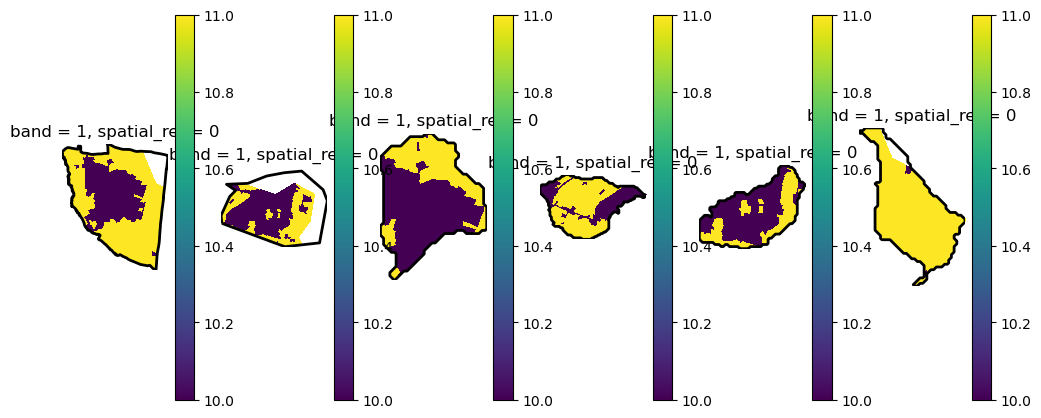

In [23]:
fig, axs =plt.subplots(ncols=6, figsize =(12,5))
for region_name in ['Kippax', 'Garforth', 'Kippax_West', 'Garforth_East', 'Garforth_West', 'South_Catchment']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    if region_name == 'Kippax_West':
        region_boundary = kippax_west_boundary
    elif region_name == 'Garforth_East':
        region_boundary = garforth_east_boundary        
    elif region_name == 'Garforth_West':
        region_boundary = garforth_west_boundary      
    elif region_name == 'South_Catchment':
        region_boundary = south_catchment_boundary              
        
    # Trim land cover data
    raster = rxr.open_rasterio("../../../../FloodModelling/LandCoverData/LandCover_urban_classification.tif", masked=True).squeeze()
    raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
    
    if not os.path.exists("../../../../FloodModelling/LandCoverData/{}/".format(region_name)):
        os.mkdir("../../../../FloodModelling/LandCoverData/{}/".format(region_name))
    raster_clipped.rio.to_raster("../../../../FloodModelling/LandCoverData/{}/LandCover_urban_classification.tif".format(region_name))
    
    # Add to 
    values,counts = np.unique(raster_clipped.data, return_counts=True)
    df[region_name] = counts
    
    if region_name == 'Kippax':
        raster_clipped.plot.imshow(ax=axs[0])
        kippax_boundary.plot(ax=axs[0], facecolor="none", edgecolor= 'black', linewidth=2)
        axs[0].set_axis_off()
    elif region_name == 'Garforth':
        raster_clipped.plot.imshow(ax=axs[1])
        garforth_boundary.plot(ax=axs[1], facecolor="none", edgecolor= 'black', linewidth=2)
        axs[1].set_axis_off()
        
    elif region_name == 'Kippax_West':
        raster_clipped.plot.imshow(ax=axs[2])
        kippax_west_boundary.plot(ax=axs[2], facecolor="none", edgecolor= 'black', linewidth=2)
        axs[2].set_axis_off()
    elif region_name == 'Garforth_East':
        raster_clipped.plot.imshow(ax=axs[3])
        garforth_east_boundary.plot(ax=axs[3], facecolor="none", edgecolor= 'black', linewidth=2)
        axs[3].set_axis_off()        
    elif region_name == 'Garforth_West':
        raster_clipped.plot.imshow(ax=axs[4])
        garforth_west_boundary.plot(ax=axs[4], facecolor="none", edgecolor= 'black', linewidth=2)
        axs[4].set_axis_off()       
    elif region_name == 'South_Catchment':
        raster_clipped.plot.imshow(ax=axs[5])
        south_catchment_boundary.plot(ax=axs[5], facecolor="none", edgecolor= 'black', linewidth=2)
        axs[5].set_axis_off()                     

### Look at proportion of each which is urban
NB: NA refers to cells which are not within the boundary of the catchment (because we initially trimmed the catchment using the bounding box of the catchment)

In [24]:
# The proportion of the area which is in within the catchment boundary
for column in df.columns[1:]:
    percent_urban = round((df[column][0]/ (df[column][1] + df[column][0]))*100,1)
    print("% of {} which is urban: ".format(column), percent_urban)

% of WholeCatchment which is urban:  27.0
% of Kippax which is urban:  36.2
% of Garforth which is urban:  59.5
% of Kippax_West which is urban:  64.4
% of Garforth_East which is urban:  34.1
% of Garforth_West which is urban:  64.8
% of South_Catchment which is urban:  1.0
